### Polynomial Regression

If our data is more complex than a straight line, we can still fit a linear model to nonlinear data by adding powers of each feature as new features and then train the linear model on this extended set of features. 

In [1]:
import numpy as np
m = 100 
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [2]:
from sklearn.preprocessing import PolynomialFeatures 
poly_features = PolynomialFeatures(degree = 2, include_bias = False) # Add second degree polynomial to features
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.8252683])

In [3]:
X_poly[0] # Contains the original feature of X plus the square of the feature 

array([-0.8252683 ,  0.68106776])

In [4]:
# Now fit linear regression to this extended data 
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.1225504]), array([[0.97882993, 0.50676682]]))

When there are multiple features, Polynomial Regression is capable of finding relationships between features by adding combinations of features up to a given degree. 
Eg. two features a, b with degree=3 --> 

$a^{3}$, $b^{3}$, $a^{2}$, $b^{2}$, $a^{2}b$, $b^{2}a$, $ab$

#### Learning curves

Learning curves are plots of the model's performance on the training and the validation set as a function of the training set size (or the training iteration). To generate these plots, we train the model several times on different sized subsets of the training set. 

In [5]:
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label = "train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth = 3, label = "val")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(['training', 'validation'])

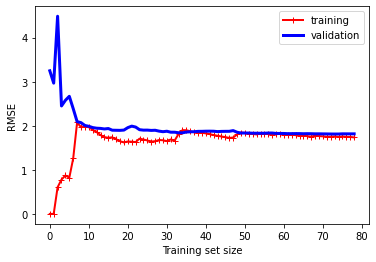

In [8]:
# Performance of a linear regression model 
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

**Training error**:
* When there are only few training instances, the model can fit the perfectly, which is why the training learning curve starts at 0. 
 * As new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly because the data is noisy and not linear. 
 * Error on the training data goes up until it reaches a plateau. 


**Validation error**: 
 * When the model is trained on few instances, it is uncapable of generalizing properly, which is why the validation error is initially big. 
 * As the model is shown more training examples, the validation error goes down. 
 * Error on the validation data reaches a plateau. 
 

These learning curves are typical of a model that is **UNDERFITTING**: both curves reached a plateau and are close and fairly high. 

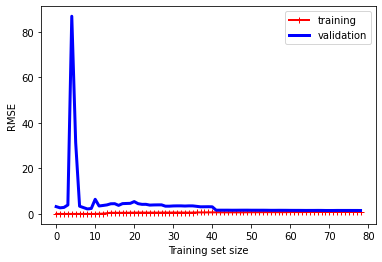

In [9]:
# Performance of a 10-th degree polynomial 
from sklearn.pipeline import Pipeline 
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

**Training error**
 * Lower than when using Logistic Regression only 
 * There is a gap between the curves, meaning that the model performs significantly better on the training data than the validation data --> sign of overfitting. 

#### Bias-variance trade-off

A model's generalization error can be expressed as the sum of 3 errors: 

 1. **BIAS** = part of the generalization error due to **wrong assumptions** (eg. the data is linear when it is actually quadratic) --> high bias model is likely to **underfit the training data**. 
 2. **VARIANCE** = due to the model's excessive **sensitivity to small variations** in the training data. --> model with many degrees of freedom is likely to have high variance and **overfit the training data**.
 3. **IRREDUCIBLE ERROR** = due to **noisiness** of the data itself. The only way to reduce this part of the error is to clean up the data. 
 
**!!** Increasing a model's complexity increases its variance and reduces its bias and vice-versa.

### Regularized Linear Models 

For a linear model, regularization is typically achieved by constraining the weights of the model.

#### 1. Ridge Regression

Regularized version of Linear Regression which forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. 

Regularizzation term: $\alpha$ $\frac{1}{2}$ $\sum_{i = 1}^{n}$ $\theta_{i}^{2}$ --> added to the cost function only during training. 

Hyperparameter $\alpha$ : controls how much you want to regularize the model. If $\alpha$ = 0, same as Linear Regression, if $\alpha$ very large, all weights are very close to 0. 

Also important to note that the bias term $\theta_{0}$ is not regularized as the sume starts at 1.  

**!!** Scale the data before performing Ridge Regression as it is sensitive to the scale of the input features. 

#### 1a. Ridge Regression with closed-form solution 

In [10]:
from sklearn.linear_model import Ridge 
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.81049806]])

#### 1b. Ridge Regression with Gradient Descent 

In [11]:
from sklearn.linear_model import SGDRegressor 
sgd_reg = SGDRegressor(penalty = "l2") # L2 norm of the weight vector 
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.79682018])

#### 2. Lasso Regression

Like Ridge, it adds a regularization term to the cost function but uses the L1 norm of the weight vector instead of the half square of the L2 norm. 

Regularization term: $\alpha$ $\sum_{i = 1}^{n}$ $|\theta_{i}|$

**!!** Tends to eliminate weights of the least important features by setting them to zero, thus automatically performing **feature selection** and outputting a sparse model. 

**!!** To avoid Gradient Descent from bouncing around the optimum at the end when using Lasso, we need to gradually reduce the learning rate during training.

**!!** Lasso cost function is not differentiable at $\theta{i}$ = 0, but Gradient Descent still works fine if we use a subgradient vector. 

In [12]:
from sklearn.linear_model import Lasso 
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.76071817])

#### 3. Elastic Net 

Middle ground between Ridge and Lasso regression. 

$r$ $\alpha$ $\sum_{i = 1}^{n}$ $|\theta_{i}|$ + $\frac{1-r}{2}$ $\sum_{i = 1}^{n}$ $\theta_{i}^{2}$

 * when $r$ = 0, Elastic Net is the same as Ridge 
 * when $r$ = 1, Elastic Net is the same as Lasso
 

In general, Elastic Net is preferred over Lasso because Lasso may behave erraticly when the number of features is greater than the number of training instances or when several features are strongly correlated. 

In [13]:
from sklearn.linear_model import ElasticNet 
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.76585208])

#### 4. Early stopping

An alternative way to regularize iterative learning algorithms (eg. Gradient Descent) is to stop training as soon as the validation error reaches a minimum. 

**!!** With Stochastic and Mini-batch Gradient Descent the curves are not so smooth, so it may be hard to know whether we have reached a minimum or not. One solution is to stop only after the validation error has been above the minimum for some time and then roll back the model parameters to the point where the validation error was at a minimum. 

#### End of notebook